In this notebook, I will try to give an introduction to the the broadband all-sky images from LWA-SV (Orville images) and how to detect transients with them. For that first we need to download some data. One hour of an .oims image dataset is around ~36 GB of data. For the purpose here, we will average the data over the frequency axis and get a reduced dataset in the HDF5 format which is only 181 MB. An example HDF5 data used in this tutorial can be found here [link](https://www.dropbox.com/scl/fi/aphssd40n4h61zxydrxvz/58936_220000_30.137MHz_49.837MHz.hdf5?rlkey=ivduhx68fz2yp7bs3ibap0gr5&dl=0). This conversion step can be carried out using the oims2hdf5.py script.

Let's import some python libraries to play with the data

In [79]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from scipy.stats import scoreatpercentile as sc

In [80]:
filepath = '../datasets/58936_220000_30.137MHz_49.837MHz.hdf5' #HDF5 file path, set your own filepath

In [81]:
hf = h5py.File(filepath,'r') # Read the HDF5 file
print(hf.keys()) #print keys to see the file contents

<KeysViewHDF5 ['header', 'image', 'time']>


As you can see, the file has mainly 3 datasets, the header/metadata information, image dataset and the time dataset. Let's take a look a look at the contents of each dataset.

In [82]:
dset1 = hf.get('image')
dset2 = hf.get('time')
dset3 = hf.get('header')
print(f"Image dataset shape: {dset1.shape}")
print(f"Time dataset shape: {dset2.shape}")
print(f"Header dataset shape: {dset3.shape}")

Image dataset shape: (720, 4, 128, 128)
Time dataset shape: (720, 4)
Header dataset shape: (720, 11)


The image dataset has 720 time steps/integrations, 4 stokes parameters, 128 x and y pixels. Similary there are 4 time components and header information for 720 time steps. The dataset contains 720 five second slices of data amounting to 3600 second / 1 hour. The time axis contents are arranged as (MJD day, Hour, Minute, Seconds). 

The header dataset contains number of integrations, image grid size, image pixel size (degrees), number of image channels, length of integration (s), starting Local Sidereal time (fraction of a day), starting frequency of observation (MHz), stopping Frequency of observation (MHz), bandwidth of the channel (MHz), Azimuth center of the image (degrees), Altitude center of the image (degrees). 

Let's take a look at the contents of the dataset in the first integration.

In [83]:
print(f"Time info (MJD, HH, MM, SS): {dset2[0,:]}")
print(f"Header info: {dset3[0,:]}")

Time info (MJD, HH, MM, SS): [5.8936e+04 2.1000e+01 5.9000e+01 5.9000e+01]
Header info: [7.200000e+02 1.280000e+02 1.015625e+00 1.980000e+02 5.000000e+00
 1.385732e-01 3.013750e+01 4.983750e+01 1.000000e-01 9.097437e+01
 8.806663e+01]


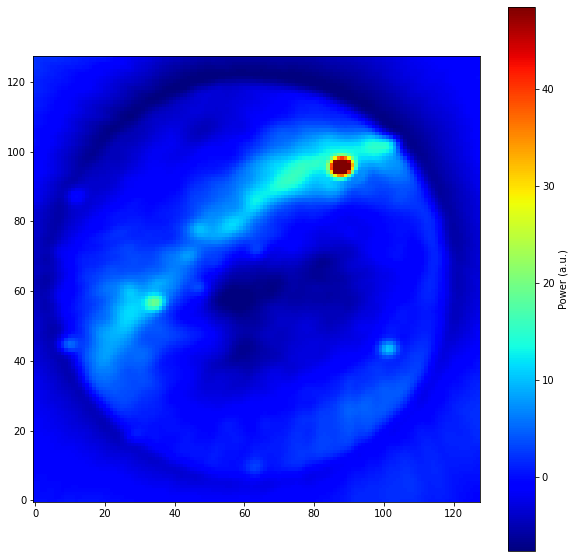

In [84]:
img = dset1[0,0,:,:] # Looking at the stokes 0/I data

# Define a plotting function here.
def plot_image(im):
    vmin = sc(im, 0.5) # Choosing the min and max percentile of the data
    vmax = sc(im, 99.9)
    fig = plt.figure(figsize = (10,10))
    plt.imshow(im.T, cmap='jet', vmin=vmin, vmax=vmax, origin = 'lower') 
    plt.colorbar(label='Power (a.u.)')
    plt.show()

plot_image(img)

The plot shows the an all-sky view from the LWA telescope projected onto a 2D plane. The bright spots represent the bright radio soures in the sky. T The center of the image represents the zenith/above head view of the telescope and the circle shows the horizon of the telescope (beyond you cannot see). The bright arc in the center of the image shows our own Milky Way Galactic plane.

We can also look at all the stokes paramer images as well.


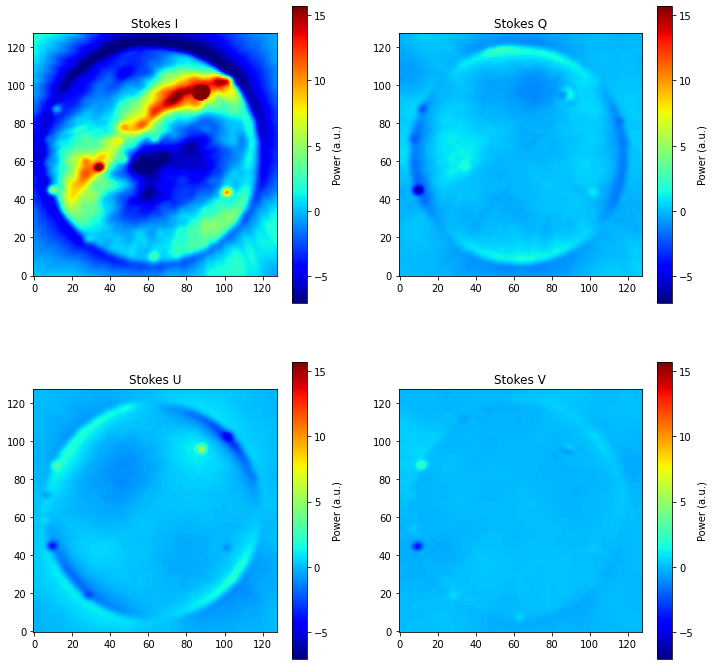

In [85]:
im_all = dset1[0,:,:,:] # Looking at the stokes 0/I data
vmin = sc(im_all, 0.5) # Choosing the min and max percentile of the data
vmax = sc(im_all, 99.9)

fig = plt.figure(figsize = (12,12))

plt.subplot(2, 2, 1)
plt.imshow(im_all[0,:,:].T, cmap='jet', vmin=vmin, vmax=vmax, origin = 'lower') 
plt.title('Stokes I')
plt.colorbar(label='Power (a.u.)')

plt.subplot(2, 2, 2)
plt.imshow(im_all[1,:,:].T, cmap='jet', vmin=vmin, vmax=vmax, origin = 'lower') 
plt.colorbar(label='Power (a.u.)')
plt.title('Stokes Q')

plt.subplot(2, 2, 3)
plt.imshow(im_all[2,:,:].T, cmap='jet', vmin=vmin, vmax=vmax, origin = 'lower') 
plt.colorbar(label='Power (a.u.)')
plt.title('Stokes U')

plt.subplot(2, 2, 4)
plt.imshow(im_all[3,:,:].T, cmap='jet', vmin=vmin, vmax=vmax, origin = 'lower') 
plt.colorbar(label='Power (a.u.)')
plt.title('Stokes V')
plt.show()

The Orville Imager produces an all-sky image like this every 5 seconds and we would like to use this as a monitoring system to detect interesting sources within the field of view. As you can see, the sky sources are relatively fainter/absent in the stokes Q, U and V and we will run the source search in the Stokes I images.

In order to do that, we use a technique called image subtraction method, where we can subtract an averege of images from a running image and then detect pixels greater than a signal to noise ratio (SNR). These sources are identified as transient sources in our pipeline. But there are some issues here. We are not interersted in finding the steady sources in the sky. We need to mask those sources before running the search algorithm. Let's do the image subtraction first. For that let's subtract average of image 2-6 from image 8.

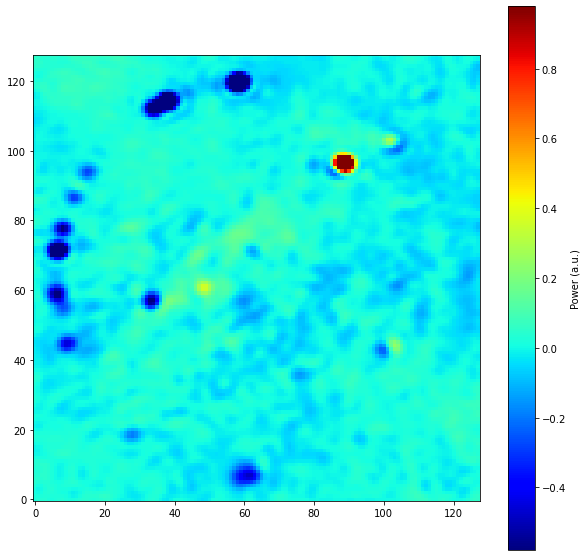

In [86]:
org_img = dset1[8,0,:,:] #Image of interest
avg_img = np.mean(dset1[2:6,0,:,:], axis = 0) # Averaging across the time axis
sub_img = org_img - avg_img

#Let's plot this subtracted image

plot_image(sub_img)

As you can see there are many positive and negative spots here. We are interested in the bright positive regions. 
But before that we have to do little bit of cleaning here. For detecting positive threshold regions, first we have to make sure that we are not seeing contributions from stead sources in the sky and also we mask region of the sky below 30 degree elevation angle. Usually, with LWA we observe lots of radio frequency interference originating from phones, transmitters, radars, etc. So we mask regions close to the horizon to reduce the false positive candidates.

For this purpose, we will use the mask_image function in the utils.py script. This functions takes in the image array, time and some metdata information to conduct masking of the bright sources and the horizon.

In [87]:
from utils import mask_image_without_sun #Utils.py also contain other functions 

# using the time and metdata of the 8th image
time = dset2[8,:]
meta = dset3[8,:]
psize = meta[2] # The physical scale (degrees) each pixel in the image corresponds to
cent_az = meta[-2] # center azimuth point in image
cent_alt = meta[-1] # center altitude point in image

lat = 34.3491 #Station Latitude (of LWA-SV)
lon = -106.886  #Station Latitude (of LWA-SV)


sub_img_mask, sub_img_mask_nohrz = mask_image_without_sun(sub_img, time, psize, lat, lon, cent_az, cent_alt)


Now let's plot and see how the images look after masking stead sources and horizon:

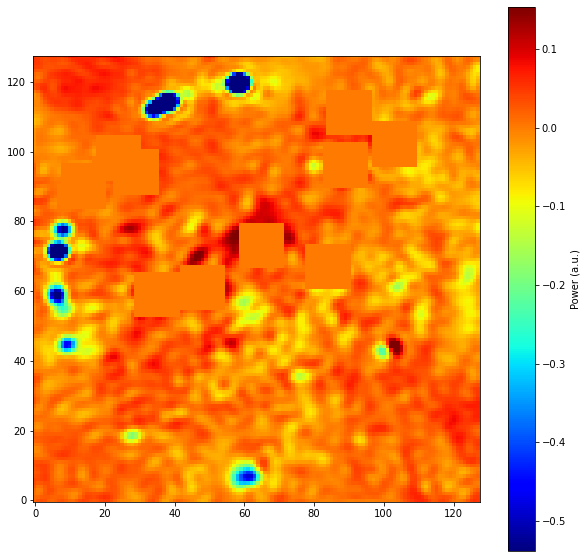

In [88]:
plot_image(sub_img_mask)

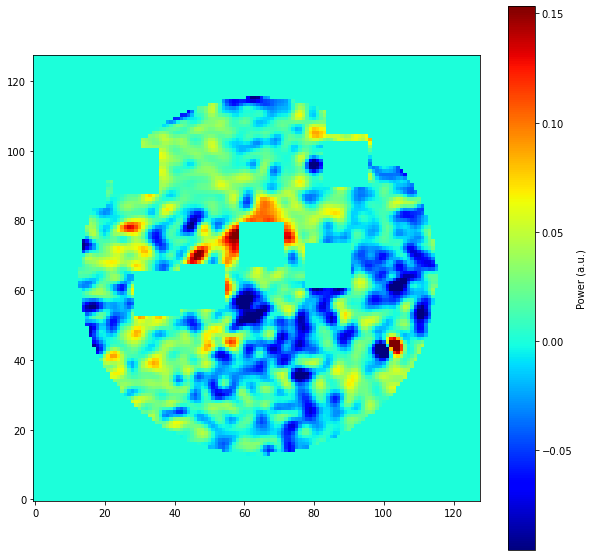

In [89]:
plot_image(sub_img_mask_nohrz)

Now a threshold based detection can be used to find the interesting regions:
For that let's calculate the mean and standard deviation of non-masked regions.

In [90]:

no_mask = sub_img_mask_nohrz != 0 #masking condition
mean  = np.mean(sub_img_mask_nohrz[no_mask]) # Mean of the non masked regions
sigma = np.std(sub_img_mask_nohrz[no_mask]) # standard deviation of the non-masked regions
print(f" Mean: {mean}, Standard deviation: {sigma}")

sig_thresh = 5 # threshold for detection
#Let's find the pixels greater than 5 times the sigma
xar, yar = np.where(((sub_img_mask_nohrz - mean) > sig_thresh*sigma) & (sub_img_mask_nohrz != 0))
print(f"X pixel array: {xar}") # printing the x pixel value
print(f"Y pixel array: {yar}") #printing the y pixel value


 Mean: 0.004547490108961428, Standard deviation: 0.03915823758379619
X pixel array: [103 103 104]
Y pixel array: [44 45 44]


As you can see there is definitely something interesting in the (103,44) position in the image. Next step is to take this pixel position and convert this into a astrophysical coordinates using pix2eq function in conversion_coord.py.

This is just an example of how the algorithm works. Now let's run the actual code used in the transient search pipeline which performs this task. In the actual pipeline, the thresholding is little different depending on the location of the sky due to the presence of bright emission flux originating from the Galactic plane. For this we will run the findtranspim function used in the wide_imager_lwasv.py and we will use only stokes I images for this task.

In [91]:
import sys
import pandas as pd
from wide_imager_lwasv_demo import findtranspim

#print(sys.version_info > (2,))

# defining some parameters needed to feed into findtranspim function
sig = 6 # sigma level for thresholding 
source_size = 6 #estimate of the number of pixels that need to be subtracted off surrounding a source
runav = 1 # Only looking for transienst in the 5 second data, choosing a different values utilize average images for search
dur = 6 # let's subtract the previous 6 images from each running image in the dataset
xsize = dset1.shape[-1]
stokes = 0 # Using stokes I

# We need to change the dataset axis to feed data into the function
data = np.transpose(dset1[:,stokes,:,:], axes = (1,2,0))
time = np.transpose(dset2, axes = (1,0)) # np.reshape(dset2[i,:],(4,))

#printing the datashape 
print(data.shape, time.shape)

#Running the transient search function on the whole dataset to get the candidate list
ra, dec, time = findtranspim(data, time, dur, sig, xsize, source_size, runav, psize, lat, lon, cent_az, cent_alt)

#concatenate the candidate values into a single numpy array
cand = np.concatenate((ra.reshape(-1,1), dec.reshape(-1,1), time.T), axis = 1)
print(cand.shape)

# Convert the array into a pandas dataframe for easy analysis
df = pd.DataFrame(cand, columns = ['RA', 'Dec', 'MJD', 'Hour', 'Minute', 'Second'])


(128, 128, 720) (4, 720)
(58, 6)


From running the pipeline on 1 hour of files, we have found a total of 58 candidates and the list contains thier coordinates and time of detection (right ascension, declination, mjd day, hour, minute, seconds).

In [92]:
# Get basic info
df.info()

#Look at the first 5 values
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RA      58 non-null     float64
 1   Dec     58 non-null     float64
 2   MJD     58 non-null     float64
 3   Hour    58 non-null     float64
 4   Minute  58 non-null     float64
 5   Second  58 non-null     float64
dtypes: float64(6)
memory usage: 2.8 KB


,RA,Dec,MJD,Hour,Minute,Second
0,119.849855,28.236404,58936.0,22.0,4.0,20.0
1,120.478663,29.746054,58936.0,22.0,4.0,20.0
2,5.524806,3.581187,58936.0,22.0,6.0,29.0
3,347.797334,40.798255,58936.0,22.0,6.0,29.0
4,344.185161,39.763573,58936.0,22.0,6.0,29.0


Let's take a look at all the 58 candidates and see how they look.

In [93]:
df

,RA,Dec,MJD,Hour,Minute,Second
0,119.849855,28.236404,58936.0,22.0,4.0,20.0
1,120.478663,29.746054,58936.0,22.0,4.0,20.0
2,5.524806,3.581187,58936.0,22.0,6.0,29.0
3,347.797334,40.798255,58936.0,22.0,6.0,29.0
4,344.185161,39.763573,58936.0,22.0,6.0,29.0
5,5.507238,3.839841,58936.0,22.0,9.0,24.0
6,5.214545,3.516160,58936.0,22.0,11.0,9.0
7,5.381537,3.516160,58936.0,22.0,11.0,49.0
8,350.000256,49.025628,58936.0,22.0,11.0,54.0
9,118.667644,29.515517,58936.0,22.0,13.0,4.0


In this list of candidates, the event at no: 42 and 43 have been identififed as a meteor producing radio emission. Their coordinate values are very close to each other and they occur at close times. These sources are known as the meteor radio afterglows (MRAs) produced by meteors entering our Earth's atmosphere at high velocities. They burn up in our atmosphere and the plsma generated in our ionosphere at a height of 100 km emit radio waves between 20-60 MHz frequency range. Let's taka a look at the images and time series of these event.

The event has an ra, dec : 107.698, 56.259 and mjd, time: 58936, 22:32:15

In [94]:
from lc_demo import get_light_curve

#let's call the time series of this event (light curve) function to track this particular event across time
lc = get_light_curve(hf, 107.698520, 56.25906, stokes)

def plot_light_curve(lc):
    # plotttingpart 
    fig, ax = plt.subplots(figsize = (14,8))
    ax.plot(lc, color='blue', marker='.', linestyle='solid')
    ax.set(xlabel='Time (integration)', ylabel='Arbitrary Power', title='Transient light curve')
    ax.grid()
    plt.show()

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


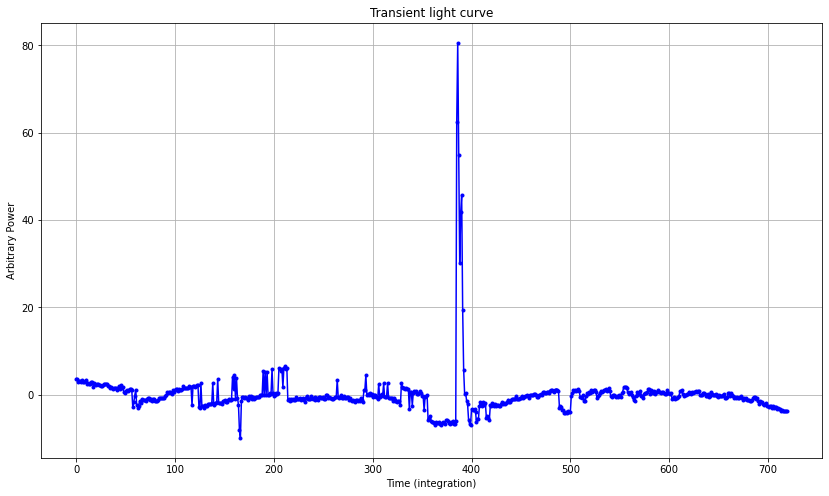

In [95]:
plot_light_curve(lc)

Here we see a nice rising signal peak corresponding to the meteor radio afterglow event. Let's take the light curve values and zoom in between integration 350 to 450 to understand the structure of this curve.

/Users/savin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


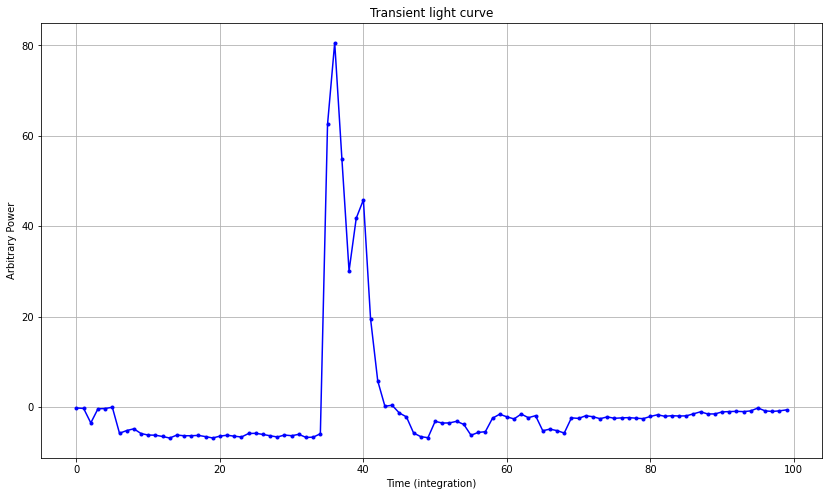

In [96]:
plot_light_curve(lc[350:450])

Each data point in time is 5 seconds and there are roughly 12 points above noise == 60 seconds duration event. Let's see how this event looks in images. The event peak is at 386th integration and we can choose 10 images between integrations 355-365. We can subtract the average (integration: 355-365) from 386th integration. 

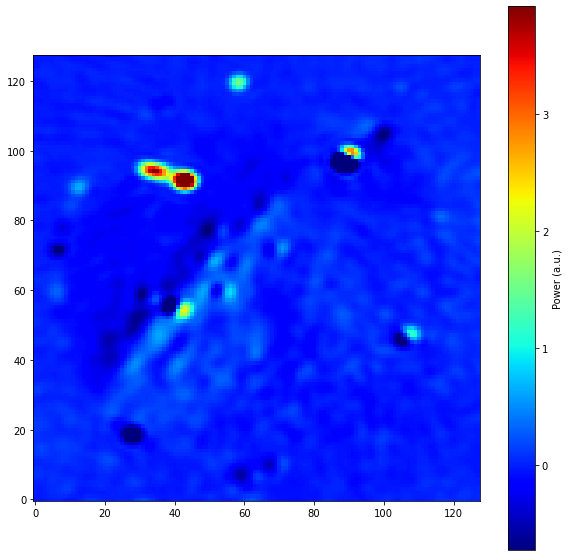

In [97]:
peak_im = dset1[386, stokes, :, :] # the event image
avg_im = np.mean(dset1[355:365, stokes, :, :], axis = 0) # average noise image
mra_im = peak_im - avg_im # subtracted image

#let's plot the MRA image
plot_image(mra_im)


There are many bright points here and the MRA source is located between x pixel 20:60 and y pixel 85:105.

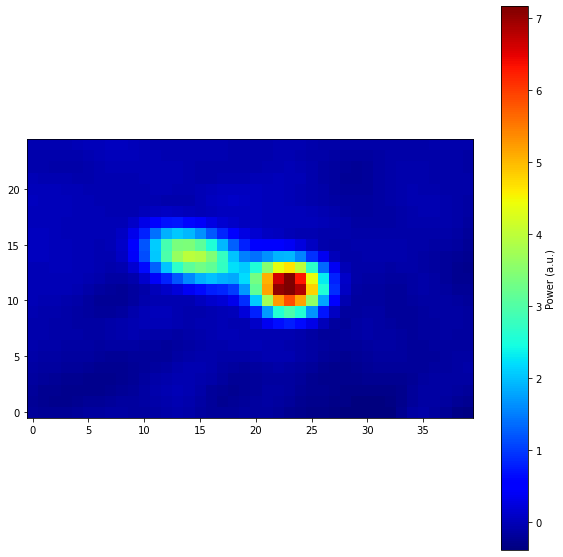

In [98]:

#lets zoom in between x pixel 20:60 and y pixel 85:105
plot_image(mra_im[20:60, 80:105])

This is a bright MRA source indentified through the pipeline. In addition to the source finding step, the pipeline also deploys several filtering techniques to reduce the false positive and increase the accuracy of the source identification. Some of these filtering requires the large .oims data files and they are skipped in this tutorial. But this tutorial is a good step for anyone interested in analyzing the LWA all-sky images.

In this way, running the pipeline on 2400 hours of images from LWA-SV discovered 86 MRAs and more details regarding the search and statistical analysis can be found in the Varghese et al. 2021 paper [link](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JA029296) published in JGR Space Physics.